In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark import StorageLevel

import random
import pickle
import pandas as pd
import numpy as np

from glob import glob
from itertools import *

import torch
import torch.nn as nn
from torch.nn.functional import sigmoid
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# makes spark -> pandas conversion faster
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [3]:
labels = [
              ('Year', IntegerType()),
              ('Month', IntegerType()),
              ('DayofMonth', IntegerType()),
              ('UniqueCarrier', StringType()),
              ('Origin', StringType()),
              ('Dest', StringType()),
              ('counts', IntegerType())
        ]
schema = StructType([StructField(x[0], x[1], True) for x in labels])

In [4]:
data = pd.read_csv('data_reg.csv')
data = data.loc[data['Year'] < 2004]
data = data.drop(columns=['UniqueCarrier', 'Dest'])
data = data.dropna()

In [5]:
data = data.groupby(['Year', 'Month', 'DayofMonth', 'Origin'])['counts'].sum().to_frame(name='counts').reset_index()

In [6]:
data

,Year,Month,DayofMonth,Origin,counts
0,2001,1,1,ABE,15
1,2001,1,1,ABI,8
2,2001,1,1,ABQ,82
3,2001,1,1,ACT,8
4,2001,1,1,ADQ,2
...,...,...,...,...,...
251453,2003,12,31,VPS,16
251454,2003,12,31,WRG,2
251455,2003,12,31,XNA,23
251456,2003,12,31,YAK,2


In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
origin_encoder = LabelEncoder()
dest_encoder = LabelEncoder()

data['Origin'] = origin_encoder.fit_transform(data['Origin'].astype(str))
with open('origin_encoder_2_v1.pkl', 'wb') as outfile:
    pickle.dump(origin_encoder, outfile)
# data['Dest'] = dest_encoder.fit_transform(data['Dest'].astype(str))

In [8]:
data = data.drop(columns=['Year'])
data

,Month,DayofMonth,Origin,counts
0,1,1,0,15
1,1,1,1,8
2,1,1,2,82
3,1,1,5,8
4,1,1,9,2
...,...,...,...,...
251453,12,31,282,16
251454,12,31,283,2
251455,12,31,285,23
251456,12,31,286,2


In [9]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(data, test_size=0.2)
valid_set, test_set = train_test_split(valid_set, test_size=0.5)

In [10]:
# counts_scaler = MinMaxScaler()
# counts = train_set.to_numpy()[:, -1]
# counts = np.expand_dims(counts, axis=1)
# counts_scaler.fit(counts)

# with open('counts_scaler.pkl', 'wb') as outfile:
#     pickle.dump(counts_scaler, outfile)

In [11]:
# train_set['counts'] = counts_scaler.transform(train_set[['counts']])
# valid_set['counts'] = counts_scaler.transform(valid_set[['counts']])
# test_set['counts'] = counts_scaler.transform(test_set[['counts']])

In [12]:
def convert_pandas_dataframe_to_pytorch_dataset(df):
    df = df.to_numpy()
    df = torch.from_numpy(df).float()
    X, y = df[:, : -1], df[:, -1].unsqueeze(1)
    return TensorDataset(X, y)

In [13]:
train_set = convert_pandas_dataframe_to_pytorch_dataset(train_set)
valid_set = convert_pandas_dataframe_to_pytorch_dataset(valid_set)
test_set = convert_pandas_dataframe_to_pytorch_dataset(test_set)

In [14]:
hidden1 = repeat( (nn.Linear(8, 8), nn.ReLU()), 50)
hidden1 = chain.from_iterable(hidden1)

hidden2 = repeat( (nn.Linear(5, 5), nn.ReLU()), 50)
hidden2 = chain.from_iterable(hidden2)

hidden3 = repeat( (nn.Linear(5, 5), nn.ReLU()), 50)
hidden3 = chain.from_iterable(hidden3)

In [15]:
class M(torch.nn.Module):
    def __init__(self, num_origin, num_dest):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(M, self).__init__()
        self.emb_size = 128
        self.origin_embs = nn.Embedding(num_origin, self.emb_size)
#         self.dest_embs = nn.Embedding(num_dest, self.emb_size)
        self.month_embs = nn.Embedding(13, self.emb_size)
        self.day_embs = nn.Embedding(32, self.emb_size)
        
        length = 3 * self.emb_size
        self.predictor = nn.Sequential(
                            nn.Linear(length, 8),
                            nn.ReLU(),
                            *hidden1,                
                            nn.Linear(8, 5),
                            nn.BatchNorm1d(5),
                            nn.ReLU(),
                            *hidden2,
                            nn.BatchNorm1d(5),
                            *hidden3,
                            nn.BatchNorm1d(5),
                            nn.Linear(5, 2),
                            nn.ReLU(),
                            nn.Linear(2, 1),
                        )

    def forward(self, X):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        month, day, origin = X[:, 0], X[:, 1], X[:, 2]
        
        origin_embs = self.origin_embs(origin.int())
#         dest_embs = self.dest_embs(dest.int())
        month_embs = self.month_embs(month.int())
        day_embs = self.day_embs(day.int())
        
        X = torch.hstack([month_embs, day_embs, origin_embs])
        y_pred = self.predictor(X)
        return y_pred

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.56E-03


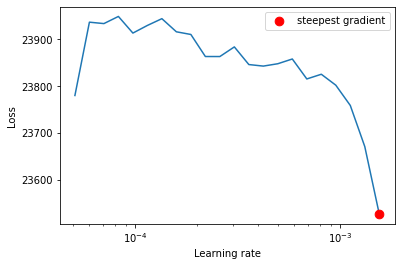

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.0015556761439304723)

In [18]:
from torch_lr_finder import LRFinder
from copy import deepcopy
num_origin = len(origin_encoder.classes_)
# num_dest = len(dest_encoder.classes_)
m = M(num_origin, None).cuda()
model = deepcopy(m)
optimizer = SGD(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()
lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
train_dataloader = DataLoader(train_set, batch_size=1024 * 64, shuffle=True)
lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
lr_finder.plot()

In [20]:
from tqdm.notebook import tqdm

train_losses = []
valid_losses = []

num_origin = len(origin_encoder.classes_)
# num_dest = len(dest_encoder.classes_)
model = M(num_origin, None).cuda()
# model = m

train_dataloader = DataLoader(train_set, batch_size=1024 * 64, shuffle=True) 
valid_dataloader = DataLoader(valid_set, batch_size=1024 * 64)

optimizer = SGD(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_dataloader), epochs=400)
loss_fn = nn.MSELoss()

for epoch in tqdm(range(400)):
    
    epoch_train_loss = 0.0
    epoch_valid_loss = 0.0
    
    optimizer.zero_grad()
    
    model.train()
    for X, y in train_dataloader:
        optimizer.zero_grad()
        
        X = X.cuda()
        y = y.cuda()
        
        pred_y = model(X)
        loss = loss_fn(pred_y, y)
        epoch_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    model.eval()
    with torch.no_grad():
        for X, y in valid_dataloader:
            X = X.cuda()
            y = y.cuda()
            
            pred_y = model(X)
            loss = loss_fn(pred_y, y)
            epoch_valid_loss += loss.item()
        
    
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
#     scheduler.step(epoch_valid_loss)
    if epoch%10 == 0:
        print(epoch, epoch_train_loss, epoch_valid_loss)  
#         torch.save(model, f'chk_2/chk_{epoch}.pt')

  0%|          | 0/400 [00:00<?, ?it/s]

0 96924.34765625 23143.419921875
10 94959.0546875 23049.14453125
20 94313.099609375 22357.5078125
30 15911.890625 7692.779296875
40 5217.3897705078125 3827.829345703125
50 4453.045166015625 1123.7694091796875
60 4176.826843261719 932.1856689453125
70 3793.0310668945312 909.8191528320312
80 3551.8071899414062 864.5204467773438
90 3449.3736572265625 801.9570922851562
100 2934.4683837890625 699.2201538085938
110 2566.2067260742188 695.6558227539062
120 2283.533447265625 571.9515991210938
130 2308.0479125976562 619.63037109375
140 2145.1244506835938 548.5498046875
150 2179.792236328125 533.7880249023438
160 2171.0757446289062 572.0164184570312
170 2111.6981201171875 519.8736572265625
180 2099.931182861328 526.3319702148438
190 2242.3455200195312 514.199951171875
200 2094.2494201660156 542.15673828125
210 2008.8706359863281 521.1221313476562
220 2005.0696411132812 511.4708557128906
230 2137.3546752929688 514.8580322265625
240 2038.3063049316406 505.0730285644531
250 2020.9572143554688 532.9

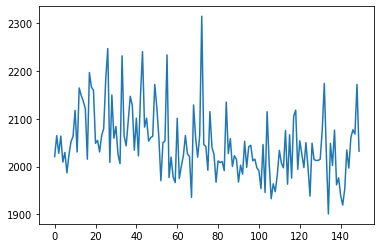

In [34]:
import matplotlib.pyplot as plt
plt.plot(train_losses[250: ])

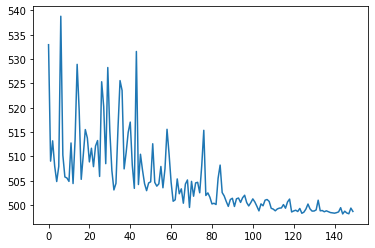

In [35]:
plt.plot(valid_losses[250:])

In [36]:
torch.save(model, 'model_v3.pt')

### Testing

In [23]:
# model = torch.load('model_outgoing_flights_2.pt')

In [24]:
model.eval()
X, y = test_set.tensors

In [25]:
y_pred = model(X.cuda())

MSE error

In [26]:
mse_err_fn = nn.MSELoss()
mse_err_fn(y_pred, y.cuda())

tensor(499.8747, device='cuda:0', grad_fn=<MseLossBackward>)

RMSE error

In [29]:
mse_err_fn = nn.MSELoss()
torch.sqrt(mse_err_fn(y_pred, y.cuda()))

tensor(22.3579, device='cuda:0', grad_fn=<SqrtBackward>)

MAP error

In [27]:
l1_err_fn = nn.L1Loss()
l1_err_fn(y_pred, y.cuda())

tensor(9.4589, device='cuda:0', grad_fn=<L1LossBackward>)

R2 score

In [28]:
from sklearn.metrics import r2_score
r2 = r2_score(y.detach().cpu().numpy(),y_pred.detach().cpu().numpy())
r2

0.9735520134332635